Semantic Segmentation Using VGGNet 16 as backbone

Dataset used : The Oxford-IIIT Pet Dataset

Link to dataset: http://www.robots.ox.ac.uk/~vgg/data/pets/

In [1]:
%tensorflow_version 2.x
import tensorflow
tensorflow.__version__

'2.2.0'

In [2]:
#import random seed
import random
random.seed(0)

import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
project_path = '/content/drive/My Drive/Semantic Segmentation/'
image_zip_path = project_path + "Copy of images.zip"

In [5]:
#using zip file function extract the zip files present in the path
from zipfile import ZipFile

with ZipFile(image_zip_path, "r") as z:
  z.extractall()

In [6]:
training_path = project_path + "train.csv"
validation_path = project_path + "validation.csv"


In [7]:
import numpy as np
import csv
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

with open(training_path, "r") as file:
  
  y_train = np.zeros((sum(1 for line in file), 56, 56))
  x_train = []
  file.seek(0)

  data = csv.reader(file, delimiter=',')

  for index, row in enumerate(data):
    for i,r in enumerate(row[1:7]):
      row[i+1] = int(r)

    path, image_height, image_width, x0, y0, x1, y1, _, _ = row
    path = "./"  + path.split('/')[-2] + "/" + path.split('/')[-1]
    path_mask = path.replace('jpg', 'png')
      
    mask_img = cv2.imread(path_mask)
    mask_img = (mask_img != 2)*1.0
    mask_img = cv2.resize(mask_img, (56, 56))
    mask_img = 1.0*(mask_img[:,:,0] > 0.2)
    y_train[index,:,:] = np.squeeze(mask_img)
    x_train.append(path)  

In [8]:
x_train[15]

'./images/Abyssinian_113.jpg'

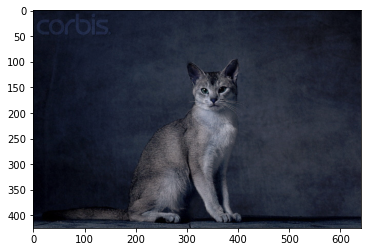

In [9]:
plt.imshow(cv2.imread(x_train[15]))

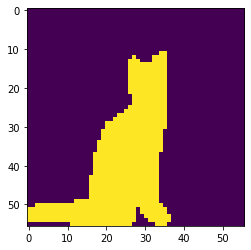

In [10]:
plt.imshow(y_train[15])

In [11]:
#since we are using VGG16, let's import the preprocess_input function
from PIL import Image
from tensorflow.keras.applications.vgg16 import preprocess_input

x_train_path = x_train

for i,f in enumerate(x_train_path):
  img = Image.open(f)
  img = img.resize((224,224))
  img = img.convert('RGB')

  x_train[i] = preprocess_input(np.array(img, dtype = np.float32))
  img.close()

In [12]:
x_train = np.array(x_train)

In [13]:
x_train.shape

(3006, 224, 224, 3)

Repeat the same procedure for the validation dataset

In [14]:
with open(validation_path, "r") as file:
  y_val = np.zeros((sum(1 for line in file), 56, 56))
  x_val = []
  file.seek(0)

  data = csv.reader(file, delimiter=",")

  for index, row in enumerate(data):
    for i, r in enumerate(row[1:7]):
      row[i+1] = int(r)

    path,image_height, image_width,x0,y0,x1,y1,_,_ = row
    path = './' + path.split('/')[-2] + "/" + path.split('/')[-1]
    path_mask = path.replace('jpg', 'png')

    mask_img = cv2.imread(path_mask)
    mask_img = (mask_img != 2) * 1.0
    mask_img = cv2.resize(mask_img, (56,56))
    mask_img = 1.0 * (mask_img[:,:,0] > 0.2)

    y_val[index,:,:] = np.squeeze(mask_img)
    x_val.append(path)

In [15]:
x_val[10]

'./images/Abyssinian_185.jpg'

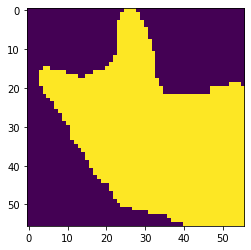

In [16]:
plt.imshow(y_val[10])

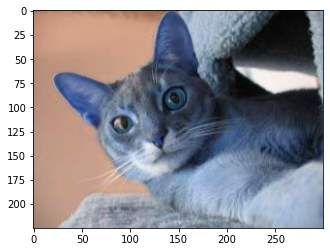

In [17]:
plt.imshow(cv2.imread(x_val[10]))

In [18]:
#preprocessing the validation dataset
x_val_path = x_val

for i,path in enumerate(x_val_path):
  img = Image.open(path)
  img = img.resize((224, 224))
  img = img.convert('RGB')

  x_val[i] = preprocess_input(np.array(img, dtype=np.float32))
  img.close()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


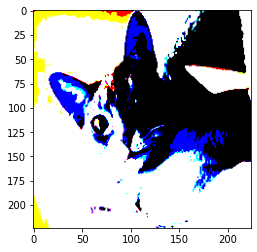

In [19]:
plt.imshow(x_val[10])

In [20]:
x_val = np.array(x_val)

In [21]:
#creating the model using vggnet
from keras.applications.vgg16 import VGG16
from keras.layers import Concatenate, Conv2D, Reshape, UpSampling2D
from keras.models import Model

def model(trainable):
  
  model = VGG16(input_shape=(224,224,3), weights = "imagenet")

  for i in range(5):
    model._layers.pop(-1)
  
  for layer in model.layers:
    layer.trainable = trainable

  # #create upsampling and concatenate it with the shallow layers to get the location level specifications
  block1 = model.get_layer("block3_conv3").output
  block2 = model.get_layer("block4_conv3").output
  block3 = model.get_layer("block5_conv3").output

  x = Concatenate()([UpSampling2D()(block3), block2])
  
  x = Concatenate()([UpSampling2D()(x), block1])

  x  = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
  x = Reshape((56, 56))(x)
  

  return Model(inputs = model.input, outputs = x)


Using TensorFlow backend.


In [22]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

In [23]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

In [24]:
vgg16_model = model(True)
vgg16_model.summary()

553467904/553467096 [==============================] - 41s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
________________________

In [25]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
vgg16_model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("model-{val_loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True, save_weights_only=True)

stop = EarlyStopping(monitor="val_loss", patience=5)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1)

In [34]:
history = vgg16_model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs=2, batch_size=32, verbose=1)

Train on 3006 samples, validate on 680 samples
Epoch 1/2
3006/3006 [==============================] - 49s 16ms/step - loss: 0.9340 - dice_coefficient: 0.9304 - val_loss: 0.9567 - val_dice_coefficient: 0.9284
Epoch 2/2
3006/3006 [==============================] - 49s 16ms/step - loss: 0.8025 - dice_coefficient: 0.9397 - val_loss: 0.8722 - val_dice_coefficient: 0.9334


In [35]:
#understanding history 
history

In [36]:
history.history.keys()

dict_keys(['val_loss', 'val_dice_coefficient', 'loss', 'dice_coefficient'])

In [37]:
history.history

{'dice_coefficient': [0.9304188, 0.93973255],
 'loss': [0.934038411833331, 0.8025443866422631],
 'val_dice_coefficient': [0.9284427165985107, 0.9333797693252563],
 'val_loss': [0.956705343022066, 0.8722080118515912]}

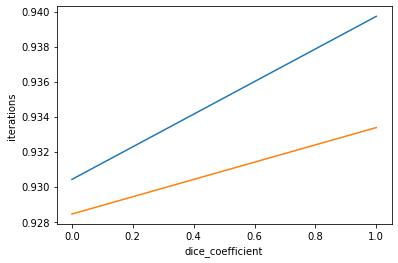

In [41]:
#visualize the details
import matplotlib.pyplot as plt

plt.plot(history.history['dice_coefficient'])
plt.plot(history.history['val_dice_coefficient'])
plt.xlabel('dice_coefficient')
plt.ylabel('iterations')
plt.show()